In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")
_set_env("HF_TOKEN")

In [2]:
from langchain.chat_models import init_chat_model

chat_model = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

In [3]:
def add(a: int, b:int) -> int:
    """Multiply a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a * b

def subtract(a: int, b:int) -> int:
    """Multiply a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a * b

def multiply(a: int, b:int) -> int:
    """Multiply a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a * b

def divide(a: int, b:int) -> int:
    """Multiply a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a * b

tools = [add, subtract, multiply, divide]
llm_with_tools = chat_model.bind_tools(tools)

In [4]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistance tasked with performing arthemation on give set of inputs. Verify your output at each step.")

def assistance(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

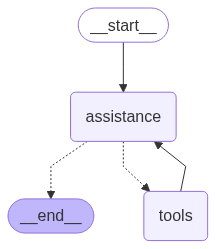

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

builder = StateGraph(MessagesState)
builder.add_node("assistance", assistance)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistance")
builder.add_conditional_edges(
    "assistance",
    # If the latest message (result) from assisatnce is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistance is not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", "assistance")
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
message = [HumanMessage(content="Add 4 and 4. Multiply the output by 2. Divide the output by 2. Subtract the output by 4.")]
message = graph.invoke({"messages": message})
message

{'messages': [HumanMessage(content='Add 4 and 4. Multiply the output by 2. Divide the output by 2. Subtract the output by 4.', additional_kwargs={}, response_metadata={}, id='46042ba6-2dde-408b-b9a9-46f58ef57b21'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"b": 4.0, "a": 4.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--e1443294-4b4f-4066-8981-e22bb3aa3620-0', tool_calls=[{'name': 'add', 'args': {'b': 4.0, 'a': 4.0}, 'id': 'e54051ac-c10b-4656-bf62-38efffc69f41', 'type': 'tool_call'}], usage_metadata={'input_tokens': 120, 'output_tokens': 5, 'total_tokens': 125, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='16', name='add', id='de2c78fe-db05-42fb-8c24-e4956f77c55b', tool_call_id='e54051ac-c10b-4656-bf62-38efffc69f41'),
  AIMessage(content='The sum of 4 and 4 is 8. Multiplying by 2 gives 16

In [16]:
for m in message['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 4 and 4. Multiply the output by 2. Divide the output by 2. Subtract the output by 4.
================================== Ai Message ==================================
Tool Calls:
  add (8730b25e-f84d-401b-a61b-cbc03fa5f234)
 Call ID: 8730b25e-f84d-401b-a61b-cbc03fa5f234
  Args:
    b: 4.0
    a: 4.0
================================= Tool Message =================================
Name: add

16
================================== Ai Message ==================================

The sum of 4 and 4 is 8. Next, I will multiply 8 by 2.
Tool Calls:
  multiply (f82f77ed-921c-41a0-acd6-cfd0004ba091)
 Call ID: f82f77ed-921c-41a0-acd6-cfd0004ba091
  Args:
    b: 2.0
    a: 8.0
================================= Tool Message =================================
Name: multiply

16
================================== Ai Message ==================================
Tool Calls:
  divide (a5a28a65-ea47-4656-8f05-1e1cf0c98cc0)
 C